In [37]:
# load packages 

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numba as nbj

from aicsimageio import AICSImage
from tqdm import tqdm 
from statannotations.Annotator import Annotator

path_to_quant = '//home/gridsan/djuna/homer/github/confocalQuant/'
sys.path.append(path_to_quant)

from confocalQuant.qc import return_channel_moments_per_im, get_day_and_time, get_metadata, return_non_unique_indices
from confocalQuant.segmentation import impose_segmentations, get_czi_files, int_to_float
from confocalQuant.data_handling import print_failed_jobs, get_meta_vectors, return_results, load_im_from_memmap, load_im_from_memmap_ravel
from confocalQuant.stats import compute_per_cell_stats
from confocalQuant.plotting import plot_boxplot_by_treatment, plot_boxplot_by_line
from confocalQuant.widgets import toggle_filters, ImageBrowser

def get_meta_vectors(in_parent, files, spacer):
    meta = pd.read_csv(in_parent + 'temp.csv')
    meta.columns = ['file', 'line', 'treatment']
    meta['well'] = [x.split(spacer)[0] for x in meta['file']]

    dictionary = dict(zip(meta['well'], meta['line']))
    dictionary2 = dict(zip(meta['well'], meta['treatment']))

    lines = np.array([dictionary[x.split(spacer)[0]] for x in files])
    treat = np.array([dictionary2[x.split(spacer)[0]] for x in files])
    return lines, treat

def plot_boxplot_by_treatment(value, line, df, colors, colors2):
    
    avg_lipidspot = df.groupby(['line', 'treatment', 'well'])[value].mean().reset_index(name='av')

    d = avg_lipidspot[avg_lipidspot['line']==line]

    ax = sns.boxplot(data = d, x = 'treatment', showfliers=False, y = 'av', dodge = True, order = ['vehicle', 'CDP-choline'], palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
    sns.stripplot(data=d, x='treatment', y='av', palette = colors2, dodge=True, jitter=True, alpha=1,  order = ['vehicle', 'CDP-choline'])

    pairs = [(("vehicle"), ("CDP-choline"))]  # Define pairs to compare
    annotator = Annotator(ax, pairs, data=d, x='treatment', y='av', order = ['vehicle', 'CDP-choline'])
    annotator.configure(test='t-test_ind', text_format='full', loc='outside', verbose=2, show_test_name=False)
    
    annotator.apply_and_annotate()
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.ylabel(value)
    plt.xlabel('')

#### Load and preprocess the quantifications

In [38]:
all_df = pd.read_csv('../../new_outs/iNbatch04242024_D54D2_12F4_out/quant_continuous.csv')
df = all_df[all_df['line'] == 'Y622']
df = df[df['treatment'] != 'rosiglitazone']
df['well'] = [i.split('_')[0] for i in df['file']]
df = df.rename(columns={'12F4': 'ab42'})

In [39]:
df.head()

,Unnamed: 0,dapi,neun,ab42,D54D2,size,file_ID,mask_ID,file,line,treatment,well
0,0,0.030581,0.059320,0.001645,0.046479,2039.0,0,1,B02_1.czi,Y622,vehicle,B02
1,1,0.007409,0.096594,0.000654,0.002347,1322.0,0,2,B02_1.czi,Y622,vehicle,B02
2,2,0.039177,0.031786,0.001201,0.005281,2473.0,0,3,B02_1.czi,Y622,vehicle,B02
3,3,0.009909,0.073568,0.002044,0.003719,697.0,0,4,B02_1.czi,Y622,vehicle,B02
4,4,0.032725,0.038590,0.001204,0.039779,2109.0,0,5,B02_1.czi,Y622,vehicle,B02


#### Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


vehicle vs. CDP-choline: t-test independent samples, P_val:4.050e-02 t=2.275e+00


Text(-48.25, 0.5, 'Ab42 fluorescent intensity')

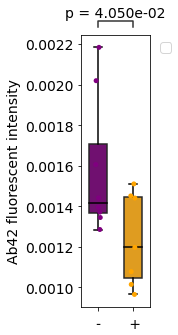

In [40]:
data = df[df['line']=='Y622']
data = data[data['treatment']!='rosiglitazone']
data.columns = ['x', 'dapi', 'neun', 'ab42', 'D54D2', 'size', 'file_ID', 'mask_ID', 'file', 'line', 'treatment', 'well']

plt.figure(figsize=(1.25,5))
colors = dict(zip(np.unique(data['treatment']), [ 'orange', 'purple']))
colors2 = dict(zip(np.unique(data['treatment']), [ 'orange', 'purple']))

plot_boxplot_by_treatment('ab42', 'Y622', data, colors, colors2)
plt.xticks(ticks=[0, 1], labels=['-', '+'], rotation=180)
plt.ylabel('Ab42 fluorescent intensity')
#plt.savefig('../out_plots/amyloid_new_cdp_choline.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 vs. Y622: t-test independent samples, P_val:7.911e-02 t=-1.841e+00
E3 vs. G2: t-test independent samples, P_val:4.535e-02 t=-2.135e+00


Text(-50.5, 0.5, 'Ab42 fluorescent intensity')

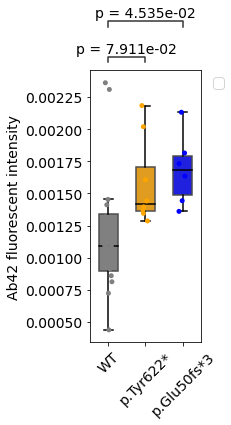

In [41]:
df = pd.read_csv('../../new_outs/iNbatch04242024_D54D2_12F4_out/quant_continuous.csv')
df = df[(df['treatment']=='vehicle')]
df['well'] = [i.split('_')[0] for i in df['file']]
df.columns = ['x', 'dapi', 'neun', 'ab42', 'D54D2', 'size', 'file_ID', 'mask_ID', 'file', 'line', 'treatment', 'well']

plt.figure(figsize=(2,5))
colors = dict(zip(np.unique(df['line']), [ 'grey' , 'blue', 'orange']))
colors2 = dict(zip(np.unique(df['line']), [ 'grey' , 'blue', 'orange']))

plot_boxplot_by_line('ab42', 'vehicle', df, colors, colors2)
plt.rcParams.update({'font.size': 14})
plt.xticks(ticks=[0, 1, 2], labels=['WT', 'p.Tyr622*','p.Glu50fs*3'], rotation=45)
plt.ylabel('Ab42 fluorescent intensity')
#plt.savefig('../out_plots/ab_new.pdf')


#### Mixed model

In [42]:
from confocalQuant.stats import fit_mixed_model

print('Y622 with and without CDP-choline:')
df_temp = df[df['line']=='Y622']
print(fit_mixed_model(df_temp[df_temp['treatment']!='rosiglitazone'], "ab42 ~ treatment", 'well'))


Y622 with and without CDP-choline:
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: ab42     
No. Observations: 1466    Method:             REML     
No. Groups:       8       Scale:              0.0000   
Min. group size:  98      Log-Likelihood:     6022.9974
Max. group size:  407     Converged:          Yes      
Mean group size:  183.2                                
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.002    0.000 12.534 0.000  0.001  0.002
Group Var     0.000    0.000                           



/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
